# 라이브러리 불러오기

In [2]:
import pandas as pd # 표 형태의 데이터 분석할 때
import numpy as np # 행렬, 다차원 계산 등 복잡한 연산할 때
import seaborn as sns # 시각화할 때
import matplotlib.pyplot as plt # 시각화할 때
from matplotlib.lines import Line2D # 중앙값 경향선 나타낼 때
from scipy import stats # 통계 분석과 검정할 때
from sklearn.preprocessing import OrdinalEncoder # 순서별 의미가 따로 있는 범주형 데이터를 라벨인코딩할 때
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 확인할 때
plt.rcParams['font.family'] = 'AppleGothic'

# 데이터 불러오기
df_ord = pd.read_csv("olist_orders_dataset.csv")
df_cust = pd.read_csv("olist_customers_dataset.csv")
df_sell = pd.read_csv("olist_sellers_dataset.csv")
df_prod = pd.read_csv("olist_products_dataset.csv")
df_ord_items = pd.read_csv("olist_order_items_dataset.csv")
df_ord_pay = pd.read_csv("olist_order_payments_dataset.csv")
df_ord_rev = pd.read_csv("olist_order_reviews_dataset.csv")
df_geo = pd.read_csv("olist_geolocation_dataset.csv")
df_cat = pd.read_csv("product_category_name_translation.csv")


# 데이터 스키마
- 8개 테이블 관계도 
- 1개 테이블 제외 (product_category_name_translation (카테고리 이름 번역))
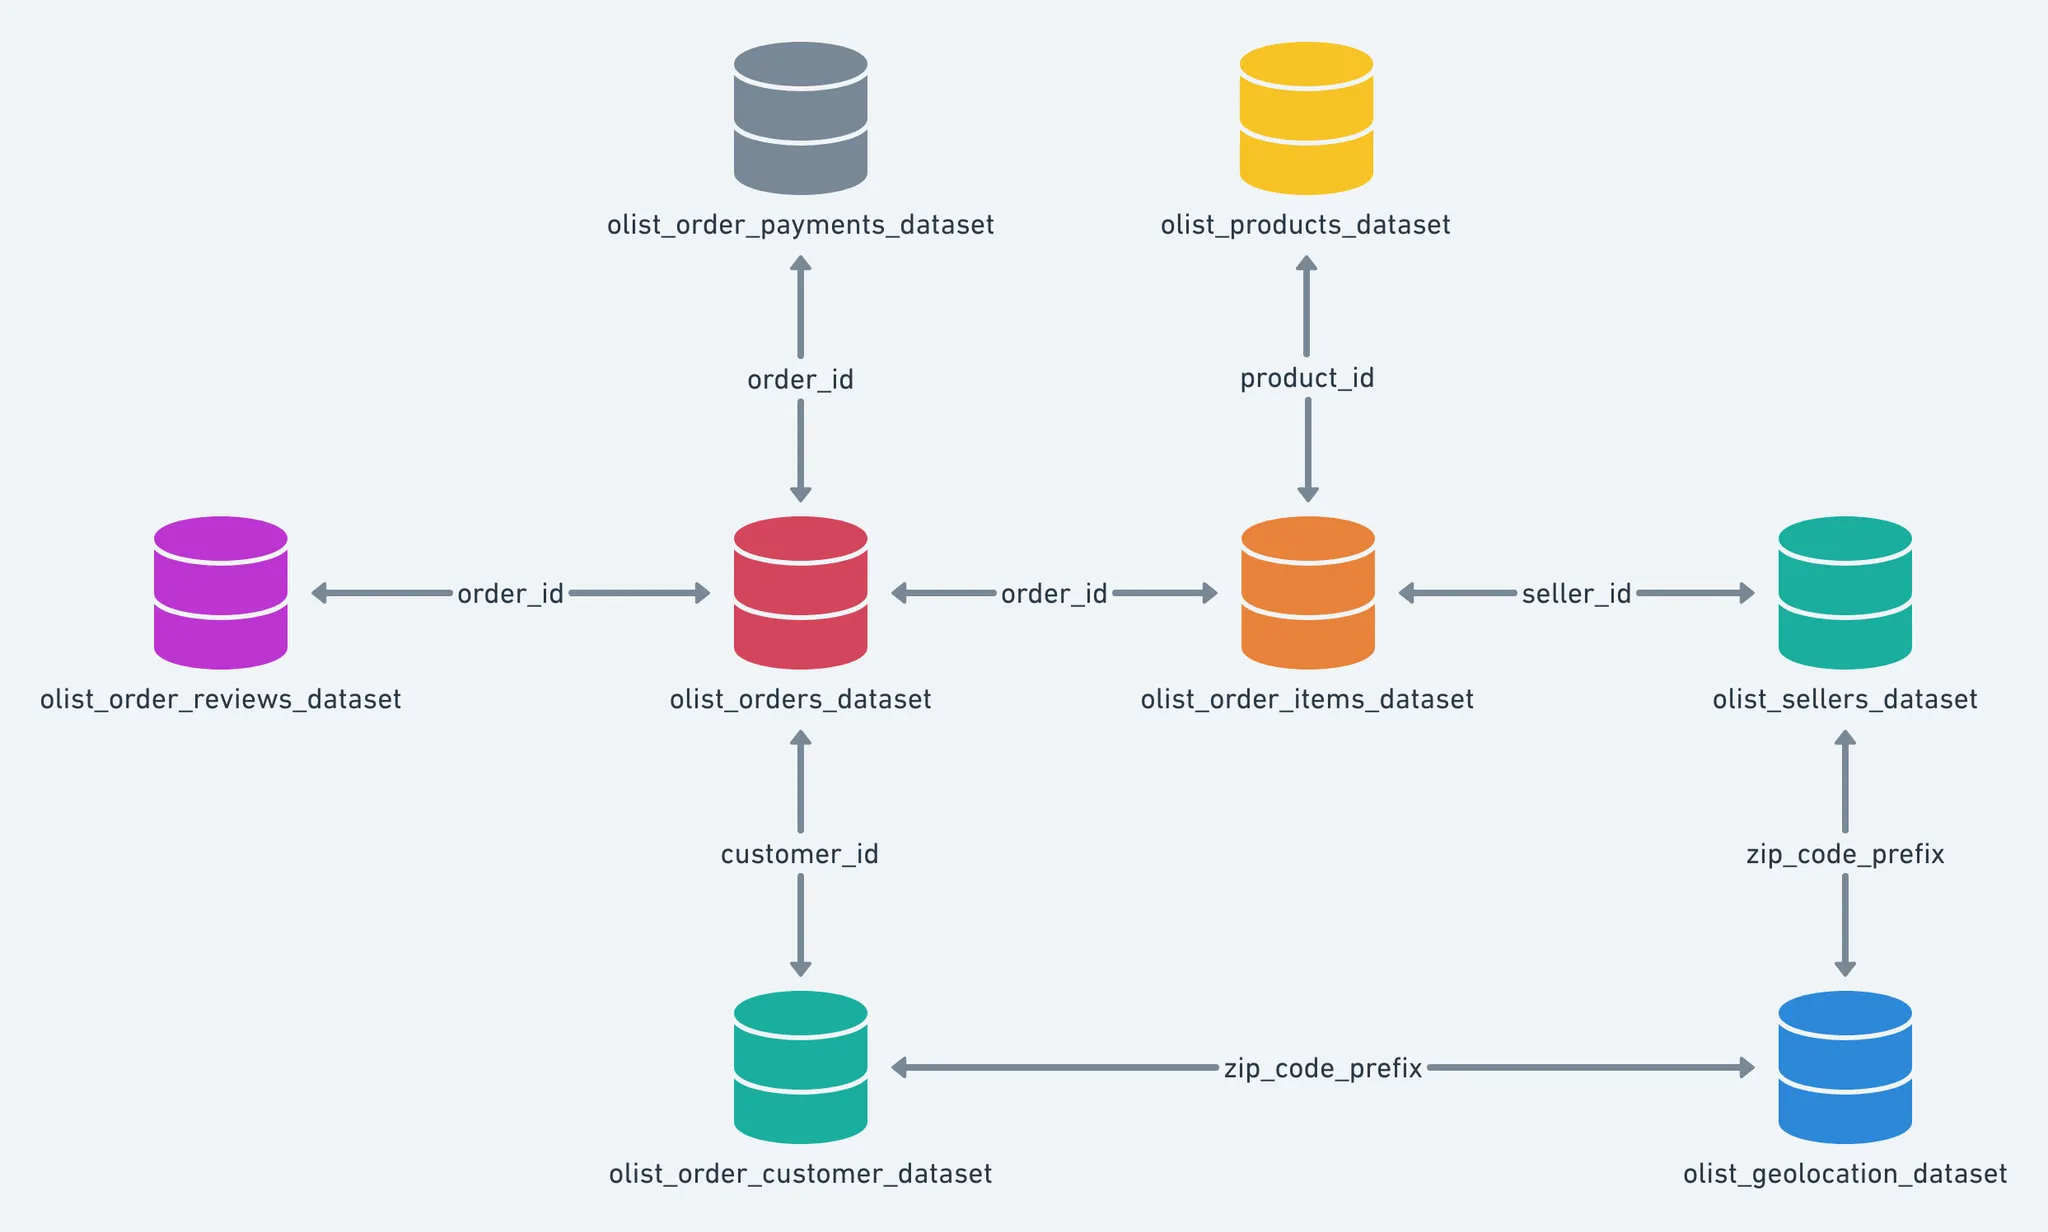

# 데이터셋 파악

- 출처: 브라질 최대 백화점인 올리스트(Olist)에서 제공
  - 올리스트(Olist) = 한국의 쿠팡?
    - 브라질 전역의 소규모 사업체를 단일 계약으로 간편하게 여러 채널에 연결하는 기업
    - 판매자는 올리스트 매장을 통해 제품을 판매하고 올리스트 물류 파트너를 통해 고객에게 직접 배송할 수 있음
- 개요: 2016년부터 2018년까지 브라질 여러 마켓플레이스에서 발생한 10만 건의 주문 정보를 담고 있는 kaggle 데이터 (9개의 CSV 파일)
- 내용: 주문 상태, 가격, 결제 및 운송 실적부터 고객 위치, 제품 속성, 그리고 고객이 작성한 리뷰까지 다양한 측면에서 주문을 확인할 수 있음
- 특이사항: 브라질 우편번호와 위도/경도 좌표를 연결하는 위치 정보 데이터도 포함


# 테이블별 정보

- olist_orders_dataset (주문) (99,441개) * 핵심 데이터셋 (주문별 각종 정보를 찾을 수 있음)
  - 각 주문에서 다른 모든 정보를 찾을 수 있음 (주문/배송완료/배송예상시간 등)
  - 컬럼명 뜻
    * order_id: 주문 고유 ID
    * customer_id: 고객 고유 ID
    * order_status: 주문 상태
    * order_purchase_timestamp: 주문 구매 시각
    * order_approved_at: 주문 승인 시각
    * order_delivered_carrier_date: 물류 파트너에게 주문이 전달된 시각
    * order_delivered_customer_date: 고객에게 주문이 배송 완료된 시각
    * order_estimated_delivery_date: 고객에게 안내된 예상 배송일

- olist_customers_dataset (고객) (99,441개)
  - 고객과 고객 위치에 대한 정보 (주문 고유 고객 식별, 주문 배송 위치 등)
  - 각 주문에 고유한 customer_id가 할당됨 (동일한 고객이라도 주문마다 다른 ID를 받게 됨)
  - customer_unique_id를 사용하는 목적은 매장에서 재구매한 고객을 식별하기 위한 것 (중복 고객 구분하기 위함)
  - 컬럼명 뜻
    * customer_id: 고객 고유 ID (주문마다의 고객 ID로 중복이 없으며 기본키 역할을 함)
    * customer_unique_id: 고객의 고유 식별자 (한 고객이 여러 번 주문할 때 동일한 ID가 여러 번 나올 수 있음)
    * customer_zip_code_prefix: 고객 우편번호 앞부분
    * customer_city: 고객 거주 도시
    * customer_state: 고객 거주 주 또는 광역자치단체

- olist_sellers_dataset (판매자) (3,095개)
  - Olist에서 주문을 처리한 판매자의 위치 정보 (물류/배송, 세금 처리 등에서 중요)
  - 판매자 위치를 찾고 각 제품을 처리한 판매자를 식별할 수 있음
  - 컬럼명 뜻
    * seller_id: 판매자 고유 ID (상품을 판매하는 판매자 식별자)
    * seller_zip_code_prefix: 판매자 우편번호 앞부분
    * seller_city: 판매자 소재 도시 (611개)
    * seller_state: 판매자 소재 주 또는 광역자치단체 (23개)
      * 'seller_state' 세부내용 (브라질의 행정구역(26개 주, 1개 연방구) 중 4개 주(AL, AP, PR, TO) 누락 -> 판매 지역 확장 제안?)
        * SP: 상파울루주 (São Paulo)
        * RJ: 리우데자네이루주 (Rio de Janeiro) 
        * PE: 페르남부쿠주 (Pernambuco)
        * PR: 파라나주 (Paraná)
        * GO: 고이아스주 (Goiás)
        * SC: 산타카타리나주 (Santa Catarina)
        * BA: 바이아주 (Bahia)
        * DF: 연방구 (Distrito Federal, 브라질리아)
        * RS: 히우그란지두술주 (Rio Grande do Sul)
        * MG: 미나스제라이스주 (Minas Gerais)
        * RN: 히우그란지두노르치주 (Rio Grande do Norte)
        * MT: 마투그로수주 (Mato Grosso)
        * CE: 세아라주 (Ceará)
        * PB: 파라이바주 (Paraíba)
        * AC: 아크리주 (Acre)
        * ES: 이스피리투산투주 (Espírito Santo)
        * RO: 혼도니아주 (Rondônia)
        * PI: 피아우이주 (Piauí)
        * MS: 마투그로수두술주 (Mato Grosso do Sul)
        * SE: 세르지피주 (Sergipe)
        * MA: 마라냥주 (Maranhão)
        * AM: 아마조나스주 (Amazonas)
        * PA: 파라주 (Pará)

- olist_products_dataset (제품) (32,951개)
  - Olist에서 판매한 제품에 대한 데이터
  - 컬럼명 뜻
    * product_id: 제품 고유 ID
    * product_category_name: 제품 카테고리 이름
    * product_name_lenght: 제품 이름 길이
    * product_description_lenght: 제품 설명 길이
    * product_photos_qty: 제품 사진 수
    * product_weight_g: 제품 무게 (그램 단위)
    * product_length_cm: 제품 길이 (센티미터 단위)
    * product_height_cm: 제품 높이 (센티미터 단위)
    * product_width_cm: 제품 너비 (센티미터 단위)

- olist_order_items_dataset (주문 항목) (112,650개)
  - 각 주문 내에서 구매된 품목에 대한 데이터 (주문 상품, 판매자, 배송, 비용 등)
  - 예: order_id = 00143d0f86d6fbd9f9b38ab440ac16f53개의 품목(동일 제품)이 있음. 각 품목의 치수와 무게에 따라 운임 계산 (각 주문의 총 운임 금액 = 제품 + 운송료)
    - 총 order_item(제품) 값: 21.33 * 3 = 63.99
    - 총 운임 가치: 15.10 * 3 = 45.30
    - 총 주문 가치(제품 + 운송료): 63.99 + 45.30 = 109.29
  - 컬럼명 뜻
    * order_id: 주문 고유 ID  (각 주문을 구별하는 고유 번호)
    * order_item_id: 주문 상품 번호 (특정 주문 내에서 상품별 식별 번호)
    * product_ids: 주문에 포함된 상품 ID들 (여러 상품이 포함될 수 있음)
    * seller_id: 판매자 고유 ID (상품을 판매하는 판매자 식별자)
    * shipping_limit_date: 배송 마감일 (해당 주문이 배송되어야 하는 최종 날짜)
    * price: 상품 가격
      - 화폐 단위는 브라질 공식 화폐 단위 헤알(BRL, Brazilian Real)로 추정 10헤알 = 약 2달러(USD)
    * freight_value: 배송비

- olist_order_payments_dataset (결제) (103,886개)
  - 주문 결제 옵션에 대한 데이터 (하나의 주문에 여러 결제 수단이 있을 수 있음)
  - 컬럼명 뜻
    * order_id: 주문 고유 번호
    * payment_sequential: 한 주문 내 여러 결제 수단이 있을 때, 결제 수단의 순서 
    * payment_type: 결제 방식 종류 (예: 신용카드, 보레토 등)
      * 보레토: 브라질에서 많이 사용하는 결제 방식으로, 결제 코드가 포함된 종이나 PDF 형태의 전표. 이 전표를 은행, 복권 가게, 은행 앱을 통해 결제할 수 있음. 온라인 구매나 공과금 납부 등에 주로 쓰이며, 신용카드의 대안으로 많이 활용됨. 은행 계좌가 없는 사람도 이용 가능하도록 고안된 결제 방식
    * payment_installments: 할부 개월 수
    * payment_value: 결제 금액
      - 화폐 단위는 브라질 공식 화폐 단위 헤알(BRL, Brazilian Real)로 추정 10헤알 = 약 2달러(USD) 
    
- olist_order_reviews_dataset (리뷰) (99,224개)
  - 고객이 작성한 리뷰에 대한 데이터 (평점, 후기 등)
  - 고객이 Olist Store에서 제품을 구매하면 판매자에게 주문 처리 알림이 전송됨
  - 고객이 제품을 수령하거나 예상 배송일이 다가오면, 이메일로 만족도 설문조사가 발송됨
  - 설문조사에 참여하면 구매 경험에 대한 메모를 남기고 의견을 남길 수 있음
  - 컬럼명 뜻
    * review_id: 리뷰 고유 ID (각 리뷰를 구별하는 고유 번호)
    * order_id: 주문 고유 ID (해당 리뷰에 연결된 주문 번호)
    * review_score: 리뷰 점수 (구매자가 매긴 평가 점수, 1~5점)
    * review_comment_title: 리뷰 제목 (리뷰의 제목)
    * review_comment_message: 리뷰 상세 내용 (구매자가 작성한 구체적인 후기)
    * review_creation_date: 리뷰 작성일자 (리뷰가 작성된 날짜와 시간)
    * review_answer_timestamp: 리뷰 답변 시각 (판매자 혹은 플랫폼에서 리뷰에 답변한 날짜와 시간)

- olist_geolocation_dataset (지리적 위치) (1,000,163개)
  - 브라질 우편번호와 위도/경도 좌표 정보 
  - 고객 또는 상품의 위치를 파악하여 지역 맞춤형 서비스, 배송 최적화, 지역별 마케팅 등에 활용 가능
  - 지도 그려서 판매자와 고객 간의 거리 계산 가능
  - 컬럼명 뜻
    * geolocation_zip_code_prefix: 지리적 위치의 우편번호 앞부분 (일부 국가에서는 우편번호의 처음 부분만 저장)
    * geolocation_lat: 위도 (지리적 위치의 위도 좌표)
    * geolocation_lng: 경도 (지리적 위치의 경도 좌표)
    * geolocation_city: 시/도 이름 (도시 또는 지역명)
    * geolocation_state: 주 또는 광역지역 이름 (행정 구역명)

- product_category_name_translation (카테고리 이름 번역) (71개)
  - 제품 카테고리(포르투갈어)를 영어로 번역한 데이터
  - 제품을 쉽게 탐색하고 찾을 수 있도록 도와주며, 마케팅과 검색 최적화에도 활용 가능
  - 컬럼명 뜻
    * product_category_name: 제품 카테고리 이름 (포르투갈어)
    * product_category_name_english: 제품 카테고리 이름 (영어)
      - 상세 제품명 뜻은 팀 figma 참조


# EDA & 데이터 전처리 (Data Preprocessing)

## 데이터 개수 확인

In [3]:
print(f"df_ord: {df_ord.shape}")
print(f"df_cust: {df_cust.shape}")
print(f"df_sell: {df_sell.shape}")
print(f"df_prod: {df_prod.shape}")
print(f"df_ord_items: {df_ord_items.shape}")
print(f"df_ord_pay: {df_ord_pay.shape}")
print(f"df_ord_rev: {df_ord_rev.shape}")
print(f"df_geo: {df_geo.shape}")
print(f"df_cat: {df_cat.shape}")

df_ord: (99441, 8)
df_cust: (99441, 5)
df_sell: (3095, 4)
df_prod: (32951, 9)
df_ord_items: (112650, 7)
df_ord_pay: (103886, 5)
df_ord_rev: (99224, 7)
df_geo: (1000163, 5)
df_cat: (71, 2)


## 중복 데이터 확인 -> geo 데이터 중 261,831개(26%) 중복 -> 우편번호 앞글자만 따 와서 중복값으로 보이는 건가? 모든 컬럼이 동일한 행을 중복으로 판단한 거 아닌지?

In [4]:
print(f"df_ord: {df_ord.duplicated().sum():,}건")
print(f"df_cust: {df_cust.duplicated().sum():,}건")
print(f"df_sell: {df_sell.duplicated().sum():,}건")
print(f"df_prod: {df_prod.duplicated().sum():,}건")
print(f"df_ord_items: {df_ord_items.duplicated().sum():,}건")
print(f"df_ord_pay: {df_ord_pay.duplicated().sum():,}건")
print(f"df_ord_rev: {df_ord_rev.duplicated().sum():,}건")
print(f"df_geo: {df_geo.duplicated().sum():,}건")
print(f"df_cat: {df_cat.duplicated().sum():,}건")

df_ord: 0건
df_cust: 0건
df_sell: 0건
df_prod: 0건
df_ord_items: 0건
df_ord_pay: 0건
df_ord_rev: 0건
df_geo: 261,831건
df_cat: 0건


In [24]:
# 중복에 해당하는 행만 확인
df_geo[df_geo.duplicated]
# 모든 행 다 보려면 pd.set_option('display.max_rows', None)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
15,1046,-23.546081,-46.644820,sao paulo,SP
44,1046,-23.546081,-46.644820,sao paulo,SP
65,1046,-23.546081,-46.644820,sao paulo,SP
66,1009,-23.546935,-46.636588,sao paulo,SP
67,1046,-23.546081,-46.644820,sao paulo,SP
...,...,...,...,...,...
1000153,99970,-28.343273,-51.873734,ciriaco,RS
1000154,99950,-28.070493,-52.011342,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS


## 결측치 확인

In [6]:
print(f"df_ord: {df_ord.isnull().sum().sum():,}건")
print(f"df_cust: {df_cust.isnull().sum().sum():,}건")
print(f"df_sell: {df_sell.isnull().sum().sum():,}건")
print(f"df_prod: {df_prod.isnull().sum().sum():,}건")
print(f"df_ord_items: {df_ord_items.isnull().sum().sum():,}건")
print(f"df_ord_pay: {df_ord_pay.isnull().sum().sum():,}건")
print(f"df_ord_rev: {df_ord_rev.isnull().sum().sum():,}건")
print(f"df_geo: {df_geo.isnull().sum().sum():,}건")
print(f"df_cat: {df_cat.isnull().sum().sum():,}건")

df_ord: 4,908건
df_cust: 0건
df_sell: 0건
df_prod: 2,448건
df_ord_items: 0건
df_ord_pay: 0건
df_ord_rev: 145,903건
df_geo: 0건
df_cat: 0건


### delivered_customer_date이 가장 중요하므로, 해당 결측치만 삭제하면 어떨지? 

In [ ]:
df_ord.isnull().sum()


order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

### 제품 데이터(32,951개) 중 결측치수(2448개)는 많지 않으므로(7%) 모두 삭제?

In [7]:
df_prod.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

### 리뷰 분석을 '평점' 중심으로 풀어갈 거면 결측치를 기본값(No comment)으로 대체, 감정분석 할거면 결측치 삭제?

In [8]:
df_ord_rev.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

## 테이블 정보 확인

In [ ]:
# 모든 테이블 정보
print(df_ord.info())
print(df_cust.info())
print(df_sell.info())
print(df_prod.info())
print(df_ord_items.info())
print(df_ord_pay.info())
print(df_ord_rev.info())
print(df_geo.info())
print(df_cat.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-

## 테이블 상세 내용 확인

In [9]:
df_ord

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [11]:
df_cust

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [13]:
df_prod

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [15]:
df_ord_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [17]:
df_ord_pay

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54


In [19]:
df_sell

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS


In [ ]:
# 판매자 소재 도시 고유값 확인
df_sell['seller_city'].unique()

array(['campinas', 'mogi guacu', 'rio de janeiro', 'sao paulo',
       'braganca paulista', 'brejao', 'penapolis', 'curitiba', 'anapolis',
       'itirapina', 'tubarao', 'lauro de freitas', 'imbituba', 'brasilia',
       'porto seguro', 'guaruja', 'tabatinga', 'salto', 'tres de maio',
       'belo horizonte', 'arapongas', 'sao bernardo do campo', 'tatui',
       'garopaba', 'camanducaia', 'tupa', 'guarulhos',
       'sao jose dos pinhais', 'sao ludgero', 'sao jose', 'piracicaba',
       'porto alegre', 'congonhal', 'santo andre', 'osasco', 'valinhos',
       'joinville', 'saquarema', 'barra velha', 'petropolis',
       'santo antonio da patrulha', 'ponta grossa', 'santana de parnaiba',
       'sao carlos', 'ibitinga', 'barueri', 'caxias do sul', 'araguari',
       'contagem', 'jaragua do sul', 'lages - sc', 'bento goncalves',
       'catanduva', 'ribeirao pires', 'jaboticabal', 'echapora', 'cotia',
       'rio do sul', 'sorocaba', 'pradopolis', 'itaborai', 'mirassol',
       'birigui',

In [ ]:
# 판매자 소재 도시 개수 확인 (611개)
len(df_sell['seller_city'].unique())

611

In [ ]:
# 판매자 소재 행정구역(주 또는 광역자치단체) 고유값 확인
df_sell['seller_state'].unique()

array(['SP', 'RJ', 'PE', 'PR', 'GO', 'SC', 'BA', 'DF', 'RS', 'MG', 'RN',
       'MT', 'CE', 'PB', 'AC', 'ES', 'RO', 'PI', 'MS', 'SE', 'MA', 'AM',
       'PA'], dtype=object)

In [ ]:
# 판매자 소재 도시 개수 확인 (23개)
# 브라질의 행정구역(26개 주, 1개 연방구) 중 4개 주(AL, AP, PR, TO) 누락 -> 판매 지역 확장 제안?
len(df_sell['seller_state'].unique())

23

In [25]:
df_ord_rev

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


In [28]:
df_geo

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS
1000161,99980,-28.388932,-51.846871,david canabarro,RS


In [30]:
df_cat

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
66,flores,flowers
67,artes_e_artesanato,arts_and_craftmanship
68,fraldas_higiene,diapers_and_hygiene
69,fashion_roupa_infanto_juvenil,fashion_childrens_clothes


In [32]:
df_sell['seller_state'].unique()

array(['SP', 'RJ', 'PE', 'PR', 'GO', 'SC', 'BA', 'DF', 'RS', 'MG', 'RN',
       'MT', 'CE', 'PB', 'AC', 'ES', 'RO', 'PI', 'MS', 'SE', 'MA', 'AM',
       'PA'], dtype=object)

# 기초 통계량 확인

In [7]:
display(df_ord.describe(include='all').T) 
display(df_cust.describe(include='all').T)
display(df_sell.describe(include='all').T)
display(df_prod.describe(include='all').T)
display(df_ord_pay.describe(include='all').T)
display(df_ord_rev.describe(include='all').T)
display(df_geo.describe(include='all').T)
display(df_cat.describe(include='all').T)

# display: 통계 정보를 시각적으로 보기 좋게 출력
# describe(include='all'): 모든 열(숫자/문자/범주형 등 포함)에 대해 각 열의 기초 통계 요약 정보 확인
# T: 컬럼별 통계치를 한 줄씩 보기 쉽게 전치(Transpose) = 행과 열을 뒤집어 각 열이 한 행(row)씩 되도록 정렬
# top:  해당 열에서 가장 많이 나온 값(최빈값, mode)
# freq: 그 최빈값이 데이터에 등장한 횟수

,count,unique,top,freq
order_id,99441,99441,e481f51cbdc54678b7cc49136f2d6af7,1
customer_id,99441,99441,9ef432eb6251297304e76186b10a928d,1
order_status,99441,8,delivered,96478
order_purchase_timestamp,99441,98875,2018-04-11 10:48:14,3
order_approved_at,99281,90733,2018-02-27 04:31:10,9
order_delivered_carrier_date,97658,81018,2018-05-09 15:48:00,47
order_delivered_customer_date,96476,95664,2018-05-08 23:38:46,3
order_estimated_delivery_date,99441,459,2017-12-20 00:00:00,522


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,99441,99441,06b8999e2fba1a1fbc88172c00ba8bc7,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_unique_id,99441,96096,8d50f5eadf50201ccdcedfb9e2ac8455,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_zip_code_prefix,99441.0,NaN,NaN,NaN,35137.474583,29797.938996,1003.0,11347.0,24416.0,58900.0,99990.0
customer_city,99441,4119,sao paulo,15540,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_state,99441,27,SP,41746,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
seller_id,3095,3095,3442f8959a84dea7ee197c632cb2df15,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seller_zip_code_prefix,3095.0,NaN,NaN,NaN,32291.059451,32713.45383,1001.0,7093.5,14940.0,64552.5,99730.0
seller_city,3095,611,sao paulo,694,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seller_state,3095,23,SP,1849,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
product_id,32951,32951,1e9e8ef04dbcff4541ed26657ea517e5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_category_name,32341,73,cama_mesa_banho,3029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_name_lenght,32341.0,NaN,NaN,NaN,48.476949,10.245741,5.0,42.0,51.0,57.0,76.0
product_description_lenght,32341.0,NaN,NaN,NaN,771.495285,635.115225,4.0,339.0,595.0,972.0,3992.0
product_photos_qty,32341.0,NaN,NaN,NaN,2.188986,1.736766,1.0,1.0,1.0,3.0,20.0
product_weight_g,32949.0,NaN,NaN,NaN,2276.472488,4282.038731,0.0,300.0,700.0,1900.0,40425.0
product_length_cm,32949.0,NaN,NaN,NaN,30.815078,16.914458,7.0,18.0,25.0,38.0,105.0
product_height_cm,32949.0,NaN,NaN,NaN,16.937661,13.637554,2.0,8.0,13.0,21.0,105.0
product_width_cm,32949.0,NaN,NaN,NaN,23.196728,12.079047,6.0,15.0,20.0,30.0,118.0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
order_id,103886,99440,fa65dad1b0e818e3ccc5cb0e39231352,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_sequential,103886.0,NaN,NaN,NaN,1.092679,0.706584,1.0,1.0,1.0,1.0,29.0
payment_type,103886,5,credit_card,76795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_installments,103886.0,NaN,NaN,NaN,2.853349,2.687051,0.0,1.0,1.0,4.0,24.0
payment_value,103886.0,NaN,NaN,NaN,154.10038,217.494064,0.0,56.79,100.0,171.8375,13664.08


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
review_id,99224,98410,7b606b0d57b078384f0b58eac1d41d78,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_id,99224,98673,c88b1d1b157a9999ce368f218a407141,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_score,99224.0,NaN,NaN,NaN,4.086421,1.347579,1.0,4.0,5.0,5.0,5.0
review_comment_title,11568,4527,Recomendo,423,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_comment_message,40977,36159,Muito bom,230,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_creation_date,99224,636,2017-12-19 00:00:00,463,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_answer_timestamp,99224,98248,2017-06-15 23:21:05,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
geolocation_zip_code_prefix,1000163.0,NaN,NaN,NaN,36574.166466,30549.33571,1001.0,11075.0,26530.0,63504.0,99990.0
geolocation_lat,1000163.0,NaN,NaN,NaN,-21.176153,5.715866,-36.605374,-23.603546,-22.919377,-19.97962,45.065933
geolocation_lng,1000163.0,NaN,NaN,NaN,-46.390541,4.269748,-101.466766,-48.573172,-46.637879,-43.767709,121.105394
geolocation_city,1000163,8011,sao paulo,135800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
geolocation_state,1000163,27,SP,404268,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,unique,top,freq
product_category_name,71,71,beleza_saude,1
product_category_name_english,71,71,health_beauty,1


## 이상치 처리

## 결제 금액(payment_value) 이상치 확인

In [65]:
# 결제 금액 최소값/최대값 이상치 의심
print(f"\n결제 금액 범위: {df_ord_pay['payment_value'].min():.2f} ~ {df_ord_pay['payment_value'].max():.2f}")



결제 금액 범위: 0.00 ~ 13664.08


In [ ]:
# 결제 금액 최소값 이상치 의심 -> 데이터 오류나 비정상 거래 가능성 -> 삭제 필요
df_ord_pay[df_ord_pay['payment_value'] == 0]


,order_id,payment_sequential,payment_type,payment_installments,payment_value
19922,8bcbe01d44d147f901cd3192671144db,4,voucher,1,0.0
36822,fa65dad1b0e818e3ccc5cb0e39231352,14,voucher,1,0.0
43744,6ccb433e00daae1283ccc956189c82ae,4,voucher,1,0.0
51280,4637ca194b6387e2d538dc89b124b0ee,1,not_defined,1,0.0
57411,00b1cb0320190ca0daa2c88b35206009,1,not_defined,1,0.0
62674,45ed6e85398a87c253db47c2d9f48216,3,voucher,1,0.0
77885,fa65dad1b0e818e3ccc5cb0e39231352,13,voucher,1,0.0
94427,c8c528189310eaa44a745b8d9d26908b,1,not_defined,1,0.0
100766,b23878b3e8eb4d25a158f57d96331b18,4,voucher,1,0.0


In [68]:
# IQR 방법으로 이상치 탐지
Q1 = df_ord_pay['payment_value'].quantile(0.25)
Q3 = df_ord_pay['payment_value'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_ord_pay[(df_ord_pay['payment_value'] < lower_bound) | (df_ord_pay['payment_value'] > upper_bound)]

print(f"\n[IQR 기반 이상치]")
print(f"하한: {lower_bound:.2f}")
print(f"상한: {upper_bound:.2f}")
print(f"이상치 개수: {len(outliers):,}개 ({len(outliers)/len(df_ord_pay)*100:.2f}%)")


[IQR 기반 이상치]
하한: -115.78
상한: 344.41
이상치 개수: 7,981개 (7.68%)


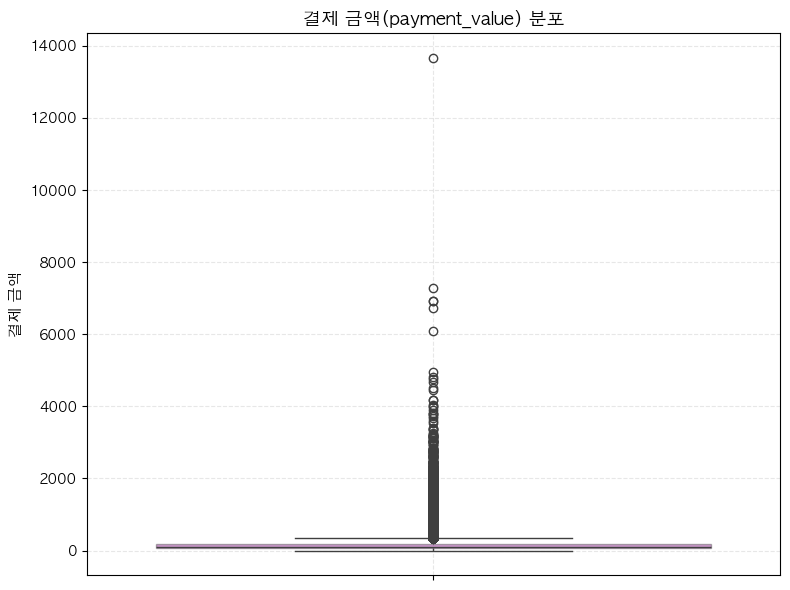

In [10]:
# 박스플롯으로 재확인
plt.figure(figsize=(8,6))
sns.boxplot(df_ord_pay['payment_value'], 
            boxprops={'facecolor': 'purple', 'alpha':0.4})

plt.title('결제 금액(payment_value) 분포', fontsize=13)
plt.ylabel('결제 금액', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# 감정분석 

## 딥러닝 모델 구현 패키지 huggingface

- 딥러닝 모델을 쉽게 사용하고 학습할 수 있도록 도와주는 오픈소스 라이브러리 및 플랫폼
- 주로 자연어처리(NLP) 분야에서 다양한 사전 학습된 딥러닝 모델(예: BERT, GPT, RoBERTa 등)을 손쉽게 활용하고 파인튜닝할 수 있도록 지원
- 여러 딥러닝 프레임워크(PyTorch, TensorFlow 등)와 호환
- 공식 사이트 https://huggingface.co/

## 감정분석 코드 예시

In [35]:
# 감정분석 코드 예시 (필요한 모델 찾아서 사용하면 됨)
from transformers import pipeline

# 1) 텍스트 분류 파이프라인 생성 (감정 분석용 사전학습 모델)
classifier = pipeline("sentiment-analysis")

# 2) 예시 문장 분석
texts = [
    "I love this product! It's absolutely wonderful.",
    "I'm really disappointed. It didn't work as expected."
]
results = classifier(texts)

print(results)

# 두 문장 분석 결과 각각 POSITIVE 99.9%, NEGATIVE 99.9% 로 정확

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


[{'label': 'POSITIVE', 'score': 0.9998815059661865}, {'label': 'NEGATIVE', 'score': 0.9997958540916443}]


## 감정분석 코드를 우리 데이터에 반영해 보기

## 일부 리뷰만 돌려 보기

In [ ]:
# 구매자 후기 고유값 조회
df_ord_rev['review_comment_message'].unique()

array([nan, 'Recebi bem antes do prazo estipulado.',
       'Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa',
       ...,
       'O produto não foi enviado com NF, não existe venda sem NF, com certeza fico no aguardo do envio da NF podendo ser por e-mail.',
       'Excelente mochila, entrega super rápida. Super recomendo essa loja!',
       'meu produto chegou e ja tenho que devolver, pois está com defeito , não segurar carga'],
      shape=(36160,), dtype=object)

In [ ]:
# 구매자 후기 모든 값 조회
for all_review in df_ord_rev['review_comment_message'].unique():
    print(all_review)


nan
Recebi bem antes do prazo estipulado.
Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa
aparelho eficiente. no site a marca do aparelho esta impresso como 3desinfector e ao chegar esta com outro nome...atualizar com a marca correta uma vez que é o mesmo aparelho
Mas um pouco ,travando...pelo valor ta Boa.

Vendedor confiável, produto ok e entrega antes do prazo.
GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E ESSA COMPRA AGORA ME DECPCIONOU
Péssimo
Loja nota 10
obrigado pela atençao amim dispensada
A compra foi realizada facilmente.
A entrega foi efetuada muito antes do prazo dado.
O produto já começou a ser usado e até o presente,
sem problemas.
relógio muito bonito e barato.
Não gostei ! Comprei gato por lebre
Sempre compro pela Internet e a entrega ocorre antes do prazo combinado, que acredito ser o prazo máximo. No stark o prazo máximo já se esgotou e ainda não recebi o produto.
Recebi exatamente o que esperava. As demais encome

In [36]:
# 포르투갈어 리뷰 분석 모델 활용 코드
from transformers import pipeline

# 포르투갈어 감정 분석 파이프라인 생성 (bertweet-pt-sentiment 모델 사용)
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="pysentimiento/bertweet-pt-sentiment"
)

# 분석할 포르투갈어 리뷰 예시 (우리 데이터 몇 개 넣어 봄)
reviews = [
    "Recebi bem antes do prazo estipulado.",
    "Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa",
    "O produto não foi enviado com NF, não existe venda sem NF, com certeza fico no aguardo do envio da NF podendo ser por e-mail.",
    "Excelente mochila, entrega super rápida. Super recomendo essa loja!",
    "meu produto chegou e ja tenho que devolver, pois está com defeito , não segurar carga"
]

# 리뷰별 감정 분석 실행
results = sentiment_analyzer(reviews)

# 결과 출력
for review, result in zip(reviews, results):
    print(f"리뷰: {review}")
    print(f"감정: {result['label']}, 확신도: {result['score']:.2f}\n")


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use mps:0


리뷰: Recebi bem antes do prazo estipulado.
감정: NEU, 확신도: 0.87

리뷰: Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa
감정: POS, 확신도: 0.99

리뷰: O produto não foi enviado com NF, não existe venda sem NF, com certeza fico no aguardo do envio da NF podendo ser por e-mail.
감정: NEU, 확신도: 0.84

리뷰: Excelente mochila, entrega super rápida. Super recomendo essa loja!
감정: POS, 확신도: 0.99

리뷰: meu produto chegou e ja tenho que devolver, pois está com defeito , não segurar carga
감정: NEG, 확신도: 0.75



## 모든 리뷰 돌려 보기 시도 (너무 오래걸려서 중단)

In [49]:
# 포르투갈어 리뷰 분석 모델 활용 코드
from transformers import pipeline

# 파이프라인 생성
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="pysentimiento/bertweet-pt-sentiment"
)

# 리뷰 리스트 생성 (결측 제거)
reviews = df_ord_rev['review_comment_message'].dropna().tolist()

# 배치 사이즈 설정 및 결과 리스트 초기화
batch_size = 1000
all_results = []

# 배치별 감정 분석
for start in range(0, len(reviews), batch_size):
    batch_reviews = reviews[start:start + batch_size]
    batch_results = sentiment_analyzer(batch_reviews)
    all_results.extend(batch_results)

# 결과 출력 예시
for review, result in zip(reviews, all_results):
    print(f"리뷰: {review}")
    print(f"감정: {result['label']}, 확신도: {result['score']:.2f}\n")


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use mps:0


KeyboardInterrupt: 